# Mixup augmentation pour la classification d'images

## Introduction

Le _mixup_ est une technique d'augmentation de donnée présenté dans l'article [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)
par Zhang et al. Il utilise les formules suivantes :

![](https://i.ibb.co/DRyHYww/image.png)

Lambda prend ses valeurs dans l'intervalle [0,1] et est échantilloné à partir de la distribution Beta (https://en.wikipedia.org/wiki/Beta_distribution).

## Installation

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import keras
import matplotlib.pyplot as plt

from keras import layers

from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow.random import gamma as tf_random_gamma

## Preparation du dataset

Nous allons utiliser le dataset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


- x_train: array NumPy de taille (50000, 32, 32, 3) contenant les images d'entrainement. La valeur des pixels varie entre 0 et 255.

- y_train: array de taille (50000, 1) contenant les labels des données d'entrainement (entiers entre 0 et 9)

- x_test: array NumPy de taille (10000, 32, 32, 3) contenant les images de test. La valeur des pixels varie entre 0 et 255.

- y_test: array de taille (10000, 1) contenant les labels des données de test (entiers entre 0 et 9)

In [ ]:
x_train = x_train.astype("float32") / 255.0 #Normaliser pour la convergence
y_train = keras.ops.one_hot(y_train.squeeze(), 10) #One hot encoding pour le mixup

x_test = x_test.astype("float32") / 255.0
y_test = keras.ops.one_hot(y_test.squeeze(), 10)

## Hyperparamètres

In [ ]:
AUTO = tf_data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 20

## Fonctions de mixup

### Relation loi gamma et beta [Loi Gamma](https://fr.wikipedia.org/wiki/Loi_Gamma#:~:text=Si%20X%20a%20une%20distribution,de%20param%C3%A8tres%20%CE%B1%20et%20%CE%B2.)
Si X et Y sont distribuées indépendamment selon des lois Γ(α, θ) et Γ(β, θ) respectivement, alors X / (X + Y) a une distribution beta de paramètres α et β.

In [ ]:
# Génération de la distribution beta à partir de distributions gamma
def sample_beta_distribution(alpha=0.2):
    gamma_1_sample = tf_random_gamma(shape=[], alpha=alpha)
    gamma_2_sample = tf_random_gamma(shape=[], alpha=alpha)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Récupération des images et des labels
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two

    # génération d'un lambda pour cette paire d'image
    l = sample_beta_distribution(alpha)

    # Execution du mixup sur les images et les labels
    images = images_one * l + images_two * (1 - l)
    labels = labels_one * l + labels_two * (1 - l)
    return (images, labels)

## Convertir les données en tenseur

In [ ]:
# création du set de validation
val_samples = 5000 #10%
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

# Conversion en deux tenseurs
train_ds_one = (
    tf_data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
)
train_ds_two = (
    tf_data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
)

# Création des paires de Batch pour le mixup
train_ds = tf_data.Dataset.zip((train_ds_one, train_ds_two))

# Application du mixup
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2),
    num_parallel_calls=AUTO
)
train_ds_mu = train_ds_mu.batch(BATCH_SIZE).prefetch(AUTO)

#On ne mélange pas les données pour la validation et le test
val_ds = tf_data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf_data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## Visualisation du nouveau dataset augmenté

[0.0, 0.0, 0.8516488075256348, 0.0, 0.0, 0.0, 0.14835119247436523, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.8846040368080139, 0.0, 0.0, 0.0, 0.11539596319198608, 0.0, 0.0]
[5.185604095458984e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999948143959045, 0.0, 0.0]
[0.9987049102783203, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0012950897216796875, 0.0]


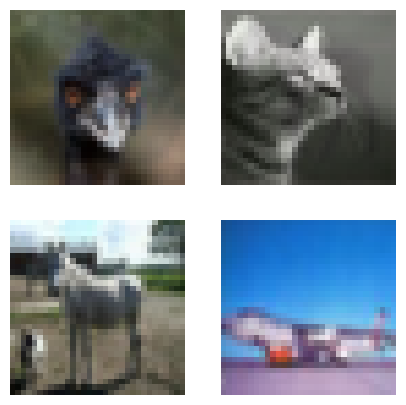

In [ ]:
# Visualisation de 4 échantillons
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(5, 5))
for i, (image, label) in enumerate(zip(sample_images[:4], sample_labels[:4])):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(image.numpy())
    print(label.numpy().tolist())
    plt.axis("off")

## Construction du modèle

In [ ]:
def get_model():
    def conv_block(x, filters):
        x = layers.Conv2D(filters, (3, 3), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(filters, (3, 3), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        return x

    inputs = layers.Input(shape=(32, 32, 3))

    # Bloc 1 : Capture des formes simples
    x = conv_block(inputs, 32)

    # Bloc 2 : Capture des textures
    x = conv_block(x, 64)

    # Bloc 3 : Capture des objets complexes
    x = conv_block(x, 128)

    # Passage au classifieur final
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)

    # Sortie Softmax pour gérer les probabilités du mixup
    outputs = layers.Dense(10, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model

## 1. Entrainement du model avec le dataset "mixup"

In [ ]:
model = get_model()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.4193 - loss: 1.6711 - val_accuracy: 0.3018 - val_loss: 1.9621
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6403 - loss: 1.1935 - val_accuracy: 0.6162 - val_loss: 1.0600
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7067 - loss: 1.0593 - val_accuracy: 0.5182 - val_loss: 1.5641
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7446 - loss: 0.9589 - val_accuracy: 0.6612 - val_loss: 0.9947
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7722 - loss: 0.9092 - val_accuracy: 0.6896 - val_loss: 0.9019
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7994 - loss: 0.8554 - val_accuracy: 0.6592 - val_loss: 1.0131
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8188 - loss: 0.8051 - val_accuracy: 0.7304 - val_loss: 0.7914
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8391 - loss: 0.7604 - val_acc

## 2. Entrainement du modèle sans le mixup

In [ ]:
# On crée une version "batchée" du dataset original pour l'ERM
train_ds_original = train_ds_one.batch(BATCH_SIZE).prefetch(AUTO)

#model = get_training_model()
model = get_model()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Notice that we are NOT using the mixed up dataset here
model.fit(train_ds_original, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.4375 - loss: 1.5233 - val_accuracy: 0.3002 - val_loss: 2.9221
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6675 - loss: 0.9290 - val_accuracy: 0.6732 - val_loss: 0.9329
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7396 - loss: 0.7411 - val_accuracy: 0.5920 - val_loss: 1.3459
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7819 - loss: 0.6203 - val_accuracy: 0.6402 - val_loss: 1.1370
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8167 - loss: 0.5196 - val_accuracy: 0.6888 - val_loss: 0.9537
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8392 - loss: 0.4609 - val_accuracy: 0.6716 - val_loss: 1.0480
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8649 - loss: 0.3920 - val_accuracy: 0.6540 - val_loss: 1.3962
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8828 - loss: 0.3314 - val_acc

## Résultats
Gain de 6% d'accuracy.